In [4]:
%load_ext autoreload
%autoreload 2

import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.test.utils import get_tmpfile
import json

%matplotlib inline

pd.set_option('display.max_columns', 500)

import pandas as pd 
import numpy as np 
import os
import re


import pandas as pd 
import numpy as np 
import os
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('tagsets')

from nltk.tokenize import TweetTokenizer

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MAGI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MAGI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MAGI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\MAGI\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


## Load scrapped data

In [5]:
# Function rto read jl file
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    return df

# Reading file
df = read_jl_file('./all_data2.jl')

In [6]:
df.head()

,Restaurant Name,Review ID,Date,Content,Rating
0,Madhu's,739447935,January 2020,The food was absolutely wonderful from prepara...,5.0
1,Madhu's,739773109,January 2020,The food was amazing. Our waiter Franco was ex...,5.0
2,Madhu's,738529074,January 2020,It was an awesome experience dining at the res...,5.0
3,Madhu's,739981237,January 2020,"Excellent service, excellent food and great am...",5.0
4,Madhu's,740251404,January 2020,Food was good cannot say too good but staff an...,4.0


## Cleaning Utilities

In [7]:
characters_to_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_", "\"", ":"]
transformation_dict = {initial:" " for initial in characters_to_remove}

with_accent = ['é', 'è', 'ê','à','ù','ô']
without_accent = ['e', 'e','e', 'a','u','o']
accent_dict = {before:after for before, after in zip(with_accent, without_accent)}

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

## Preprocessing

In [8]:
def filter(x):
    y = x.translate(str.maketrans(transformation_dict))
    z = y.translate(str.maketrans(accent_dict)) 
    w = re.sub('[^A-Za-z0-9\']+', ' ', z)
    v = replace_contractions(w)
    clean_text = v.lower()
    return clean_text
df['Review_filtered'] = df.Content.apply(lambda x:filter(x))

In [9]:
df['Review_split'] = df.Review_filtered.apply(lambda x:TweetTokenizer().tokenize(str(x)))

In [10]:
lemmatizer = WordNetLemmatizer()
def stem(words):
    stem=[]
    for word, tag in nltk.pos_tag(words):
        if tag.startswith("NN"):
            stem.append(lemmatizer.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('VB'):
            stem.append(lemmatizer.lemmatize(word, wordnet.VERB))
        elif tag.startswith('JJ'):
            stem.append(lemmatizer.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('RB'):
            stem.append(lemmatizer.lemmatize(word, wordnet.ADJ))
        else:
            stem.append(word)
    return stem
df['Review_Stem'] = df.Review_split.apply(lambda x:stem(x))

In [11]:
from stop_words import get_stop_words
stop_words = get_stop_words('en')
my_stop_words = []
all_stop_words =  stop_words + my_stop_words

In [12]:
def filter_stopwords(words):
     return [word for word in words if word not in all_stop_words] 
df['Review-stopword'] = df.Review_Stem.apply(lambda x:filter_stopwords(x))

In [13]:
df.head()

,Restaurant Name,Review ID,Date,Content,Rating,Review_filtered,Review_split,Review_Stem,Review-stopword
0,Madhu's,739447935,January 2020,The food was absolutely wonderful from prepara...,5.0,the food was absolutely wonderful from prepara...,"[the, food, was, absolutely, wonderful, from, ...","[the, food, be, absolutely, wonderful, from, p...","[food, absolutely, wonderful, preparation, pre..."
1,Madhu's,739773109,January 2020,The food was amazing. Our waiter Franco was ex...,5.0,the food was amazing our waiter franco was exc...,"[the, food, was, amazing, our, waiter, franco,...","[the, food, be, amaze, our, waiter, franco, be...","[food, amaze, waiter, franco, exceptional, att..."
2,Madhu's,738529074,January 2020,It was an awesome experience dining at the res...,5.0,it was an awesome experience dining at the res...,"[it, was, an, awesome, experience, dining, at,...","[it, be, an, awesome, experience, dining, at, ...","[awesome, experience, dining, restaurant, thur..."
3,Madhu's,739981237,January 2020,"Excellent service, excellent food and great am...",5.0,excellent service excellent food and great amb...,"[excellent, service, excellent, food, and, gre...","[excellent, service, excellent, food, and, gre...","[excellent, service, excellent, food, great, a..."
4,Madhu's,740251404,January 2020,Food was good cannot say too good but staff an...,4.0,food was good cannot say too good but staff an...,"[food, was, good, cannot, say, too, good, but,...","[food, be, good, cannot, say, too, good, but, ...","[food, good, say, good, staff, service, excell..."


## Checkpoint of preprocessing: persist to HardDisk

In [14]:
#df.to_csv("Preprocessed_reviews.csv")
#original_df.to_pickle("./dummy.pkl")
df.to_pickle("Preprocessed_reviews.pkl")

## Restore from checkpoint

In [ ]:
#df = pd.read_csv("Preprocessed_reviews.csv")
df = pd.read_pickle("Preprocessed_reviews.pkl")

In [15]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df = df.loc[:,['Review_filtered', 'Rating', 'Review-stopword']]

In [17]:
reviews = df['Review-stopword'].to_list()

#reviews= [review[2:-2].split('\', \'') for review in reviews]

In [18]:
def finalize_cleaning(reviews):
    reviews = [re.sub(r"\`+", "", word) for word in reviews]
    reviews = [re.sub(r"\.+", "", word) for word in reviews]
    reviews = [re.sub(r"\.\w", "", word) for word in reviews]
    reviews = [re.sub(r"\'", "", word) for word in reviews]
    reviews = [re.sub(r" ", "", word) for word in reviews]
    reviews = [re.sub(r"\"", "", word) for word in reviews]
    reviews = [re.sub(r"'", "", word) for word in reviews]
    reviews = [word for word in reviews if len(word)>1]
    return reviews

final_reviews = [finalize_cleaning(review) for review in reviews]

In [19]:
# Remove numbers, but not words that contain numbers.
final_reviews = [[token for token in doc if not token.isnumeric()] for doc in final_reviews]

# Remove words that are only one character.
final_reviews = [[token for token in doc if len(token) > 1] for doc in final_reviews]

In [20]:
# dimensionality check
print(len(final_reviews))
print(final_reviews[0])

488413
['sure', 'locate', 'inside', 'crypt', 'church', 'place', 'obviously', 'lot', 'character', 'vault', 'ceiling', 'walk', 'top', 'gravestone', 'dead', 'body', 'food', 'awfully', 'bland', 'main', 'meat', 'dish', 'creamy', 'chicken', 'pie', 'wife', 'vegetable', 'soup', 'need', 'several', 'packet', 'salt', 'flavor', 'bland', 'soup', 'choke', 'tasteless', 'chicken', 'pie', 'just', 'get', 'lunch', 'eat', 'many', 'cafeteria', 'museum', 'unfortunately', 'bland', 'bland', 'bland', 'area', 'national', 'gallery', 'trafalgar', 'square', 'better', 'buy', 'sandwich', 'sit', 'square', 'unless', 'course', 'weathers', 'dreary', 'warm', 'dreary', 'place', 'equally', 'dreary', 'food']


## ALTERNATIVE SOURCE (Capgemini) <font color='red'>(Do NOT execute this sector)</font>

In [ ]:
df = pd.read_csv("clean_full.csv.gzip", ### path to your dataset
                       compression='gzip',
                       low_memory=False,
                       parse_dates=['review_date', 'review_date_diner'])

In [ ]:
df = df[df.grp == "cap"]
df = df.loc[:, ['review_rating', 'review_content', 'review_content_clean']]

In [ ]:
reviews = df['review_content_clean']

In [ ]:
corpus = reviews.map(lambda review: ast.literal_eval(review)).tolist()

In [ ]:
def finalize_cleaning(reviews):
    reviews = [re.sub(r"\`+", "", word) for word in reviews]
    reviews = [re.sub(r"\.+", "", word) for word in reviews]
    reviews = [re.sub(r"\.\w", "", word) for word in reviews]
    reviews = [re.sub(r"\'", "", word) for word in reviews]
    reviews = [word for word in reviews if len(word)>1]
    return reviews
corpus = list(map(lambda review: finalize_cleaning(review), corpus))

In [ ]:
print(len(corpus))
print(corpus[0])
print(df.iloc[0,1])

## data ready:
### 1. our own data: final_reviews
### 2. Capgemini data: corpus

## BOW REPRESENTATION

In [9]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(final_reviews)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [10]:
# Bag-of-words representation of the documents.
bow_corpus = [dictionary.doc2bow(doc) for doc in final_reviews]

In [11]:
print('Capacity of VOCAB: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))

Capacity of VOCAB: 24252
Number of documents: 488413


## TF-IDF

In [12]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [13]:
len(corpus_tfidf)

488413

## LDA (Incomplete/topic extraction)

In [ ]:
# Train LDA model.
from gensim.models import LdaModel,LdaMulticore

# Set training parameters.
num_topics = 6
chunksize = 2000
passes = 10
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every)

## Save Checkpoint

In [ ]:
model.save(r'LDA.model')

In [14]:
# Load LDA model.
from gensim.models import LdaModel,LdaMulticore
model = LdaModel.load(r'LDA.model')

In [15]:
from pprint import pprint
pprint(model.print_topics())

[(0,
  '0.067*"wine" + 0.044*"dish" + 0.032*"year" + 0.022*"italian" + 0.016*"old" '
  '+ 0.016*"new" + 0.015*"bottle" + 0.015*"glass" + 0.015*"list" + '
  '0.014*"pasta"'),
 (1,
  '0.035*"us" + 0.021*"one" + 0.016*"say" + 0.014*"come" + 0.014*"waiter" + '
  '0.014*"ask" + 0.013*"give" + 0.012*"want" + 0.011*"think" + 0.011*"two"'),
 (2,
  '0.049*"table" + 0.038*"get" + 0.029*"drink" + 0.023*"wait" + 0.022*"bar" + '
  '0.021*"order" + 0.018*"busy" + 0.018*"arrive" + 0.017*"book" + '
  '0.014*"people"'),
 (3,
  '0.082*"good" + 0.033*"menu" + 0.028*"nice" + 0.023*"lunch" + 0.021*"price" '
  '+ 0.014*"find" + 0.013*"little" + 0.012*"bit" + 0.012*"choice" + '
  '0.011*"pub"'),
 (4,
  '0.064*"food" + 0.038*"service" + 0.034*"great" + 0.029*"restaurant" + '
  '0.026*"staff" + 0.024*"go" + 0.024*"place" + 0.020*"visit" + 0.018*"really" '
  '+ 0.018*"time"'),
 (5,
  '0.024*"steak" + 0.023*"main" + 0.022*"starter" + 0.020*"cook" + '
  '0.018*"chicken" + 0.016*"fish" + 0.014*"burger" + 0.014*"ch

In [16]:
vector = model[bow_corpus]
topic_weight = np.zeros([6])
for topics in vector:
    for i, topic in topics:
        topic_weight[i] += topic

In [17]:
topic_weight

array([ 38691.76528447,  94218.90579911,  71754.51541336,  83599.7560964 ,
       137044.88889373,  63103.11103583])

In [18]:
topics = model.show_topics(formatted=False, num_words=20)
print(topics)

[(0, [('wine', 0.0674782), ('dish', 0.043708857), ('year', 0.032011777), ('italian', 0.022496847), ('old', 0.016178356), ('new', 0.015734429), ('bottle', 0.015231046), ('glass', 0.01522092), ('list', 0.015174856), ('pasta', 0.014404625), ('house', 0.01425833), ('tapa', 0.012569383), ('style', 0.011533793), ('since', 0.0114466725), ('authentic', 0.010208949), ('ago', 0.009983218), ('french', 0.009846134), ('red', 0.008561702), ('la', 0.006673165), ('white', 0.0066727735)]), (1, [('us', 0.034978446), ('one', 0.02080198), ('say', 0.016123287), ('come', 0.014311689), ('waiter', 0.014174711), ('ask', 0.014073303), ('give', 0.01287312), ('want', 0.012249494), ('think', 0.011151518), ('two', 0.011001626), ('birthday', 0.010574777), ('course', 0.009502343), ('meal', 0.009378087), ('take', 0.009202563), ('waitress', 0.009107522), ('however', 0.009017283), ('tea', 0.008681787), ('leave', 0.008638642), ('know', 0.00775156), ('bill', 0.007450053)]), (2, [('table', 0.048588302), ('get', 0.03798196)

In [19]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [20]:
cols2 = cols.copy()
cols2[0] = cols[5]
cols2[5] = cols[0]

Text(0.5, 1.0, 'Relative weight of latent topics')

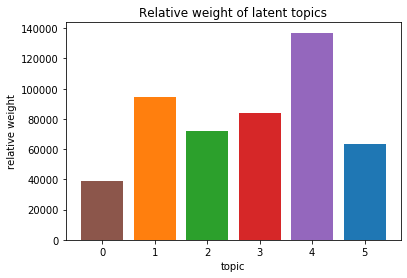

In [21]:
plt.bar(np.arange(6), topic_weight, color = cols2)
plt.xlabel('topic')
plt.ylabel('relative weight')
plt.title('Relative weight of latent topics')

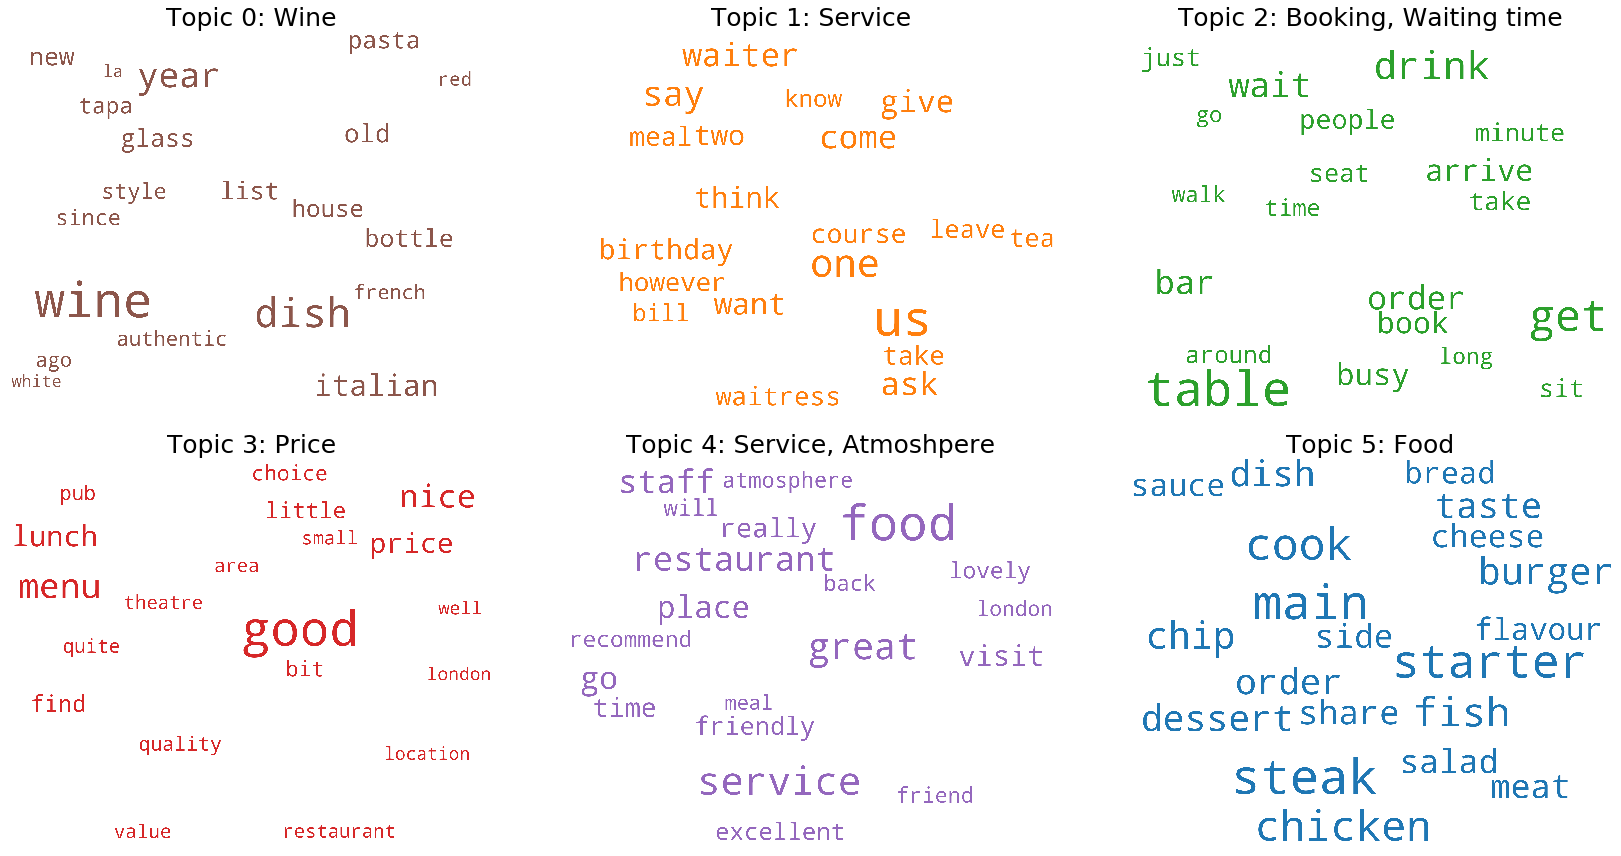

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

my_stop_words = []
all_stop_words =  my_stop_words

cloud = WordCloud(stopwords=all_stop_words,
                  background_color='white',
                  width=2500,
                  height=2000,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols2[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False, num_words=20)

fig, axes = plt.subplots(2, 3, figsize=(24,12), sharex=True, sharey=True)

titles_list = ['Wine',
              'Service',
              'Booking, Waiting time',
              'Price',
              'Service, Atmoshpere',
              'Food']


for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=250)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i) + ': ' + titles_list[i], fontdict=dict(size=25))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=model, corpus=bow_corpus, start =15, end =22, mycolors = cols2):
    corp = corpus[start:end]
    #mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(25, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model.get_document_topics(corp_cur, per_word_topics=True)
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 20:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: #' + str(start) + ' to #' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

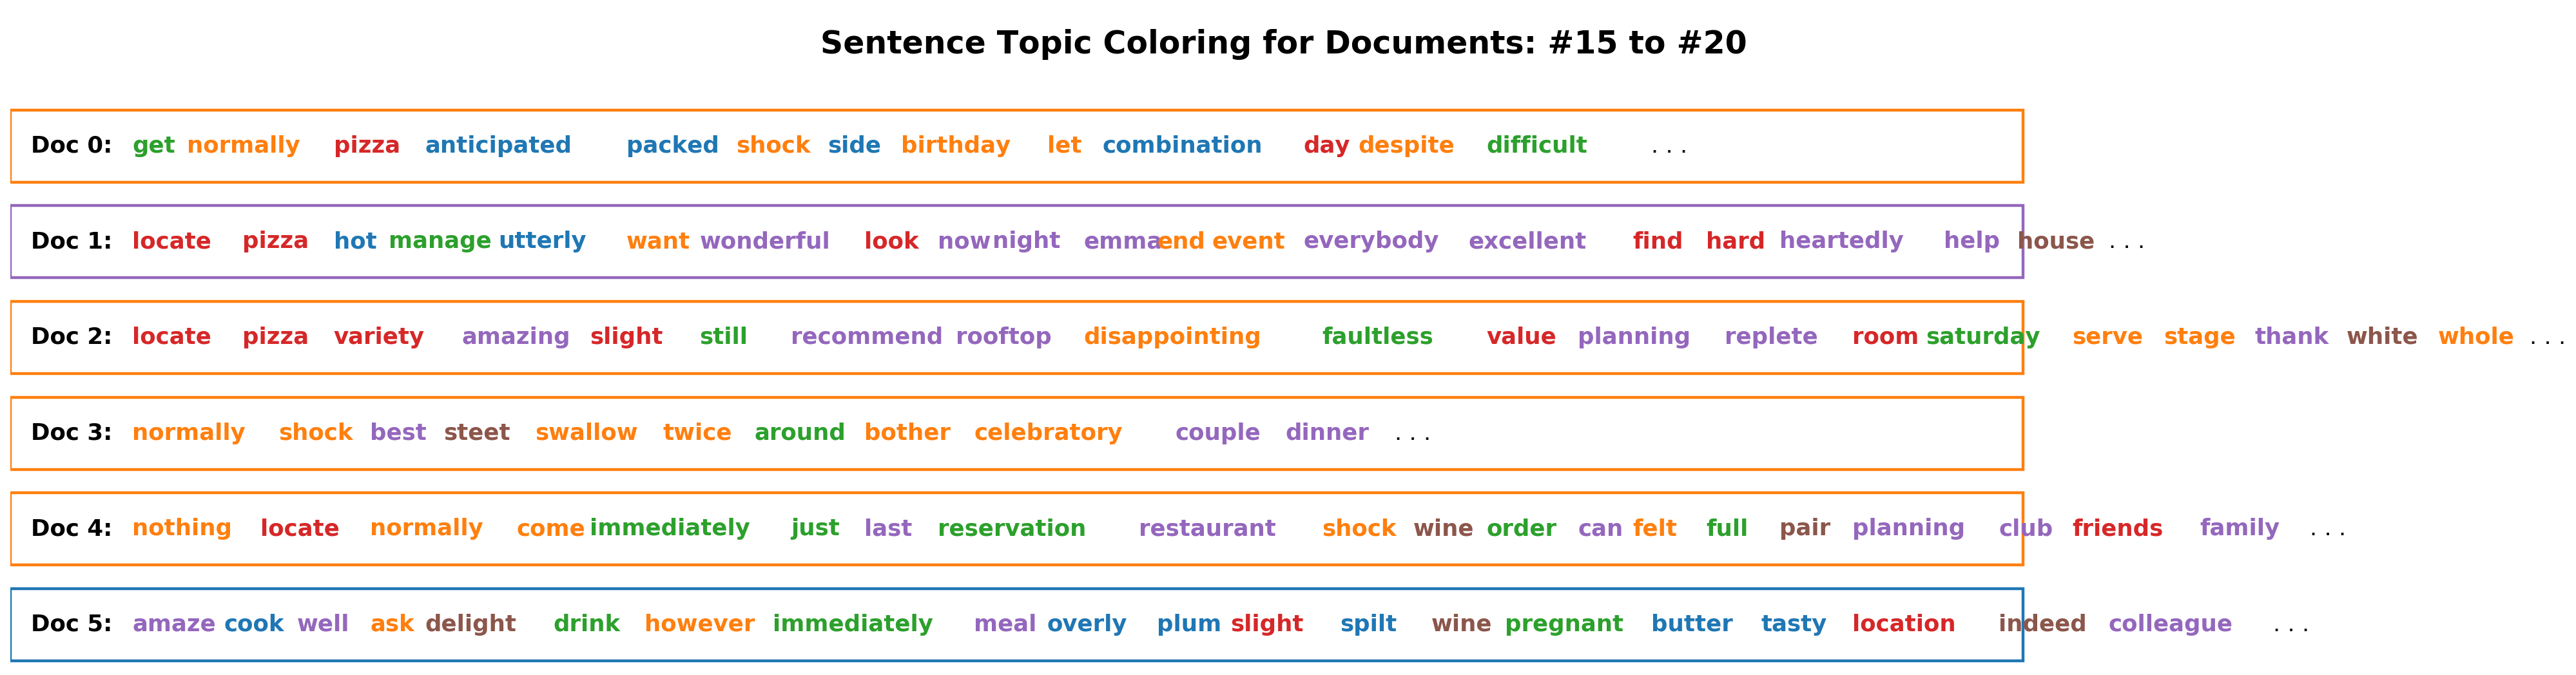

In [24]:
sentences_chart()   

## Feature extration Method 1: LSI


In [ ]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

LSImodel = LsiModel(corpus_tfidf, id2word=id2word, num_topics=300)
#LSImodel = LsiModel.load(r'LSI.model')
LSI_corpus = LSImodel[corpus_tfidf]

In [ ]:
len(LSI_corpus)

In [ ]:
LSI_features = np.zeros([488413,300])

In [ ]:
for i, row_list in enumerate(LSI_corpus):
    if i % 2000 == 0:
        print(i)
    for j, w in row_list:
        LSI_features[i,j] = w 
    
#LSI_features = pd.DataFrame(topic_weights).fillna(0).values

In [ ]:
LSI_features.shape

### CHECK POINT (Save model and features on HDD)

In [ ]:
LSImodel.save(r'LSI.model')
np.save(r'LSI_features', LSI_features)

In [ ]:
topic_num = df['Rating'].values.astype(np.int)

In [ ]:
topic_num.shape

In [ ]:
np.save(r'y', topic_num)

## Feature extration Method2: WORD2VEC

In [32]:
import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from gensim.test.utils import get_tmpfile
path = get_tmpfile("word2vec3.model")

model = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)

model.build_vocab(final_reviews)
#model.train(final_reviews, total_examples=model.corpus_count, epochs=model.iter)
#model.save("word2vec3.model")

In [33]:
model = gensim.models.Word2Vec.load("word2vec3.model")

In [34]:
word_list_good = model.wv.most_similar("good", topn=15)

In [36]:
word_list_good

[('great', 0.8069095611572266),
 ('excellent', 0.7657065391540527),
 ('decent', 0.7500655055046082),
 ('nice', 0.6808838248252869),
 ('fantastic', 0.6219403743743896),
 ('superb', 0.5811945199966431),
 ('tasty', 0.5781867504119873),
 ('outstanding', 0.576807975769043),
 ('terrific', 0.5766708254814148),
 ('exceptional', 0.5765498280525208),
 ('amaze', 0.5693332552909851),
 ('reasonable', 0.5576876401901245),
 ('brilliant', 0.5481873750686646),
 ('awesome', 0.5361567735671997),
 ('amazing', 0.5230901837348938)]

In [35]:
word_list_bad = model.wv.most_similar("bad", topn=15)

In [37]:
word_list_bad

[('terrible', 0.6700036525726318),
 ('poor', 0.6552259922027588),
 ('awful', 0.6138178706169128),
 ('horrible', 0.5825750827789307),
 ('disappointing', 0.5155379176139832),
 ('worse', 0.4933549761772156),
 ('worst', 0.4897124469280243),
 ('dreadful', 0.482247531414032),
 ('horrendous', 0.478272020816803),
 ('mediocre', 0.4722543954849243),
 ('appal', 0.4692559242248535),
 ('average', 0.46887823939323425),
 ('ok', 0.46734294295310974),
 ('appalling', 0.452869713306427),
 ('atrocious', 0.4452376961708069)]

In [38]:
embedding_matrix = dict()

for word in model.wv.vocab.keys():
    embedding_matrix[word] = list(model.wv[word])
    
embedding_matrix = pd.DataFrame(embedding_matrix)

In [39]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)


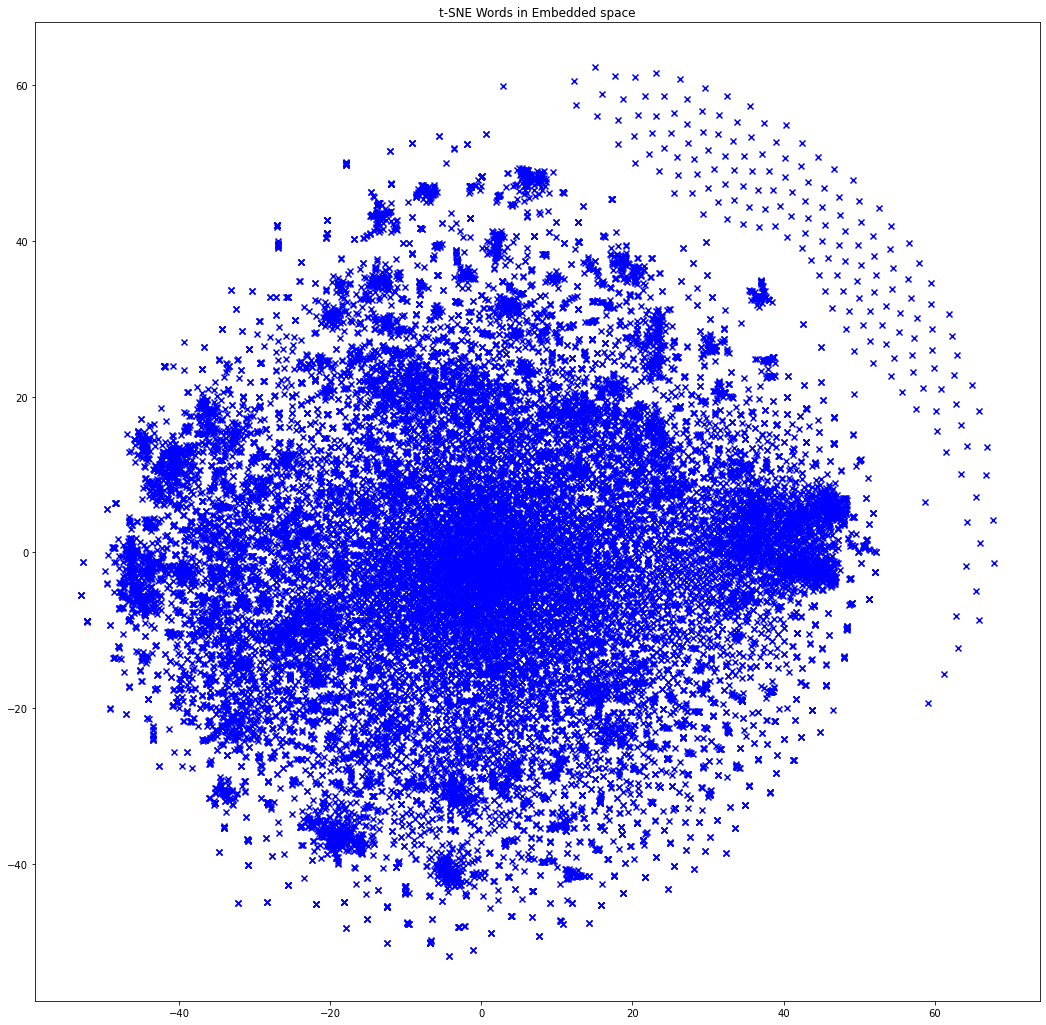

In [40]:

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(18, 18))
    plt.scatter(x_vals, y_vals, marker='x', c='blue')
    
    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 250)
    #selected_indices = lg + lb
    for i in selected_indices:
        pass
        #plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.title('t-SNE Words in Embedded space')

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_with_matplotlib(x_vals, y_vals, labels)

In [41]:
print(len(x_vals))
print(len(y_vals))
print(len(labels))


24280
24280
24280


In [ ]:
vectors = []
for review_content in final_reviews:
    review_vector = []
    for word in review_content:
        try:
            review_vector.append(list(model.wv[word]))
        except KeyError:
            pass            
    vectors.append([sum(i) for i in zip(*review_vector)])

In [ ]:
review_embedding = pd.DataFrame(vectors)
review_embedding = review_embedding/300
review_embedding.columns = ["Dimension_"+str(i) for i in range(300)]

### CHECK POINT (Save model and features on HDD)

In [ ]:
np.save(r'WV_features', review_embedding.fillna(0).values)

## Feature extraction Method3: FAST TEXT

In [21]:
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath

In [23]:
modelFT = FT_gensim(size=300)

# build the vocabulary
modelFT.build_vocab(sentences=final_reviews)

# train the model
modelFT.train(
    sentences=final_reviews, epochs=modelFT.epochs,
    total_examples=modelFT.corpus_count, total_words=modelFT.corpus_total_words
)

In [24]:
#modelFT.save(r'FT.model')
#modelFT = FT_gensim.load(r'FT.model')

In [25]:
FT_features = np.zeros([488413,300])

In [26]:
for I, review_content in enumerate(final_reviews):
    if I % 1000 == 0:
        print(I)
    features = np.zeros([300])
    for word in review_content:
        try:
            features += list(modelFT.wv[word])
        except KeyError:
            pass            
    FT_features[I,:] = features/300

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


### CHECK POINT (Save model and features on HDD)

In [27]:
np.save(r'FT_features', FT_features)

In [28]:
modelFT.save(r'FT.model')